In [1410]:
import pandas as pd
import numpy as np
from scipy.stats import skew 
import matplotlib.pyplot as plt
from scipy.special import boxcox1p
from sklearn.feature_selection import mutual_info_regression


In [1411]:
train = pd.read_csv("/Users/linuskratz/Downloads/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("/Users/linuskratz/Downloads/house-prices-advanced-regression-techniques/test.csv")

In [1412]:
len(train)

1460

In [1413]:
len(test)

1459

In [1414]:
train_Y.mean()

180881.39739190118

In [1415]:
train_id = train.pop("Id")
test_id = test.pop("Id")
train_Y = train.pop("SalePrice")
train_X = train
total_X = pd.concat([train_X, test])

<h2>Fix the Skew of the Dataset<h2>

In [1416]:
# As a challenge I wanted to solve a task using the SVR regressor. 
# The SVR Regressor is sensitive to skewed datasets. 
# The variance of the most skewed features (either right or left longtail distribution) are to be stabilized

numeric_feats = total_X.dtypes[train_X.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = total_X[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness = skewness[abs(skewness) > 1]

skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    total_X[feat] = boxcox1p(total_X[feat], lam)

In [1417]:
skewed_feats.head()

MiscVal         21.947195
PoolArea        16.898328
LotArea         12.822431
LowQualFinSF    12.088761
3SsnPorch       11.376065
dtype: float64

<h2>FILL NA Columns	<h2>

In [1418]:
NAN_columns = total_X.isnull().sum().sort_values()
NAN_columns[NAN_columns > 0]

GarageCars         1
GarageArea         1
KitchenQual        1
Electrical         1
SaleType           1
Exterior1st        1
TotalBsmtSF        1
BsmtUnfSF          1
Exterior2nd        1
BsmtFinSF1         1
BsmtFinSF2         1
BsmtFullBath       2
Functional         2
Utilities          2
BsmtHalfBath       2
MSZoning           4
MasVnrArea        23
MasVnrType        24
BsmtFinType1      79
BsmtFinType2      80
BsmtQual          81
BsmtExposure      82
BsmtCond          82
GarageType       157
GarageFinish     159
GarageYrBlt      159
GarageQual       159
GarageCond       159
LotFrontage      486
FireplaceQu     1420
Fence           2348
Alley           2721
MiscFeature     2814
PoolQC          2909
dtype: int64

In [1419]:
# for these features N/A refer to not having X in the house

features = ["BsmtFinType2", "BsmtFinType1", "BsmtExposure", "BsmtQual", "BsmtCond", "GarageType", "GarageFinish", 
         "GarageYrBlt", "GarageQual", "GarageCond", "FireplaceQu", "Fence", "Alley", "MiscFeature", "PoolQC"]

for cat in features: 
    total_X[cat] = total_X[cat].fillna("0")

In [1420]:
# for these other features N/A values indicate missing Values; fill with mode

for colname in total_X.select_dtypes("object"):
    total_X[colname]= total_X[colname].fillna(total_X[colname].mode()[0])
    #total_X[colname], _ = pd.factorize(total_X[colname])

In [1421]:
# for these features N/A values indicate missing Values; fill with mean
for cat in total_X.select_dtypes(["float64", "int64"]): 
    total_X[cat] = total_X[cat].fillna(total_X[cat].mean())

In [1422]:
# Some of the non-numeric predictors are stored as numbers; convert them into strings 
total_X['MSSubClass'] = total_X['MSSubClass'].apply(str)
total_X['YrSold'] = total_X['YrSold'].astype(str)
total_X['MoSold'] = total_X['MoSold'].astype(str)

In [1423]:
total_X.isnull().sum().sum()

0

<h2> Observe which features correlate with Target <h2>

In [1424]:
train_X_copy = total_X[:len(train_X)].copy()

discrete_features = train_X_copy.columns.get_indexer(train_X_copy.select_dtypes('object').columns)

#mutual information needs numerical types to function 
for colname in train_X_copy.select_dtypes("object"):
    train_X_copy[colname], _= pd.factorize(train_X_copy[colname])

mi_scores = mutual_info_regression(train_X_copy, train_Y, discrete_features=discrete_features)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=train_X_copy.columns)
mi_scores = mi_scores.sort_values()

In [1425]:
# the goal is to remove any outliers in these very important categories for the predictor
mi_scores[mi_scores >= 0.4]

GrLivArea       0.490634
Neighborhood    0.520624
OverallQual     0.566935
Name: MI Scores, dtype: float64

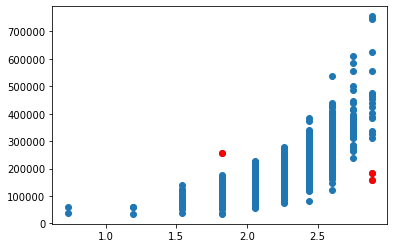

In [1426]:
# plotting most relevant features and removing outliers 
# adding these outliers to the outlier list and removing them from the dataset
plt.scatter(x=train_X_copy["OverallQual"], y=train_Y)

outliers = train_X_copy[(train_X_copy["OverallQual"] > 2.88) & (train_Y <= 200000)].index
outliers = outliers.append(train_X_copy[(train_X_copy["OverallQual"] < 2) & (train_X_copy["OverallQual"] > 1.6) & (train_Y > 200000)].index) 

plt.scatter(x=train_X_copy.loc[outliers, "OverallQual"], y = train_Y[outliers], color = "r")

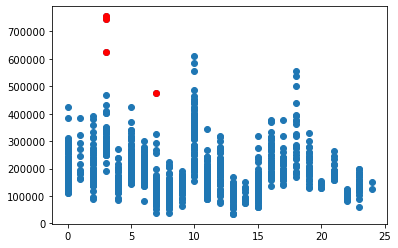

In [1427]:
plt.scatter(x=train_X_copy["Neighborhood"], y=train_Y)

new_outliers = train_X_copy[(train_X_copy["Neighborhood"] == 3) & (train_Y >= 600000)].index
new_outliers = new_outliers.append(train_X_copy[(train_X_copy["Neighborhood"] == 7) & (train_Y > 400000)].index) 

plt.scatter(x=train_X_copy.loc[new_outliers, "Neighborhood"], y = train_Y[new_outliers], color = "r")

outliers = outliers.append(new_outliers)

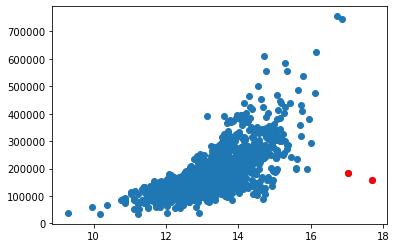

In [1428]:
plt.scatter(x=train_X_copy["GrLivArea"], y=train_Y)

new_outliers = train_X_copy[(train_X_copy["GrLivArea"] >= 17) & (train_Y <= 200000)].index

plt.scatter(x=train_X_copy.loc[new_outliers, "GrLivArea"], y = train_Y[new_outliers], color = "r")
outliers = outliers.append(new_outliers)

In [1429]:
#outliers which I considered removing when considering features with mi scores >= 0.2

outliers_old = [523, 1298, 691, 1182, 581, 1061, 1190, 185, 420, 747, 1340, \
            1350, 1169, 457, 313, 608, 1046, 710, 635, 769, 1268, 1353, 803, \
           934, 1337, 803, 1457, 249, 313, 335, 706, 581, 1061, 1190, 1298]

In [1430]:
#insert dummy features for all categorical features (non ordinal)
total_X =  pd.get_dummies(total_X)

In [1431]:
#removing outliers from the training set 
train_X = total_X[:len(train_X)]
test_X = total_X[len(train_X):]

train_X = train_X.drop(outliers)
train_Y = train_Y.drop(outliers)

<h2> Testing Random Forest vs SVR Model <h2>

In [1432]:
#using logarithmic scaling of features is not necessary for Random Forest Models but 
#it makes it easier to compare scores

from sklearn.ensemble import RandomForestRegressor

search_parameters = {
    "n_estimators": [50, 100, 150], 
    "min_samples_leaf": [2, 3], 
    "min_samples_split" : [3, 4]
}

rfr = RandomForestRegressor()
grid_rfr = GridSearchCV(estimator=rfr, param_grid=search_parameters, scoring="neg_root_mean_squared_error", cv=3)
grid_rfr = grid_rfr.fit(train_X, np.log1p(train_Y))

In [1435]:
print(f"best score: {grid_rfr.best_score_} with params: {grid_rfr.best_params_}")

best score: -0.13986711148598496 with params: {'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 150}


In [1436]:
from sklearn.svm import SVR
from sklearn.preprocessing import RobustScaler

search_parameters= {    
    "C": [10, 30, 50],
    "epsilon" : [0.001, 0.1, 0.0001], 
    "gamma" : [0.0001, 0.001, 0.1]
}

# scaling is very important for 
scaler = RobustScaler()
train_X_scal = scaler.fit_transform(train_X)


# using the log1p for train_Y because the distribution is right longtail 
svr = SVR()
grid_svr = GridSearchCV(estimator=svr, param_grid=search_parameters, scoring="neg_root_mean_squared_error", cv=3)
grid_svr = grid_svr.fit(train_X_scal, np.log1p(train_Y))

In [1437]:
print(f"best score: {grid_svr.best_score_} with params: {grid_svr.best_params_}")

best score: -0.11317647233285515 with params: {'C': 10, 'epsilon': 0.001, 'gamma': 0.001}


In [1442]:
grid_svr.best_params_

{'C': 10, 'epsilon': 0.001, 'gamma': 0.001}

In [1443]:
svr = SVR() 
svr.set_params(**grid_svr.best_params_)
svr.fit(train_X_scal, np.log1p(train_Y))

SVR(C=10, epsilon=0.001, gamma=0.001)

<h2> Create Prediction for test set <h2>

In [1444]:
# we need to reverse the log_Y parameter
prediction = np.expm1(svr.predict(scaler.transform(test_X)))

In [1445]:
#create prediction results
df = pd.concat([test_id, pd.DataFrame(prediction, columns = ["SalePrice"])], axis = 1) 

In [1446]:
df

,Id,SalePrice
0,1461,120943.448377
1,1462,172313.821210
2,1463,196518.732973
3,1464,202739.733733
4,1465,189277.094705
...,...,...
1454,2915,88947.551149
1455,2916,79107.513984
1456,2917,174819.897738
1457,2918,127800.434959


In [1447]:
df.to_csv("/Users/linuskratz/Downloads/house-prices-advanced-regression-techniques/svr_scaled.csv", index = False)